In [1]:
with open('OpenPermID-bulk-organization-20190324_072834.ttl') as f:
    content = f.readlines()


In [4]:
content[:50]

['@prefix tr-common: <http://permid.org/ontology/common/> .\n',
 '@prefix fibo-be-le-cb: <http://www.omg.org/spec/EDMC-FIBO/BE/LegalEntities/CorporateBodies/> .\n',
 '@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .\n',
 '@prefix tr-org: <http://permid.org/ontology/organization/> .\n',
 '@prefix mdaas: <http://ont.thomsonreuters.com/mdaas/> .\n',
 '@prefix tr-fin: <http://permid.org/ontology/financial/> .\n',
 '\n',
 '<https://permid.org/1-5000884086>\n',
 '        a                               tr-org:Organization ;\n',
 '        mdaas:HeadquartersAddress       "United States\\n"^^xsd:string ;\n',
 '        tr-common:hasPermId             "5000884086"^^xsd:string ;\n',
 '        tr-org:hasActivityStatus        tr-org:statusActive ;\n',
 '        tr-org:hasPrimaryBusinessSector\n',
 '                <https://permid.org/1-4294952860> ;\n',
 '        tr-org:hasPrimaryEconomicSector\n',
 '                <https://permid.org/1-4294952740> ;\n',
 '        tr-org:hasPrimaryIndustryGroup 

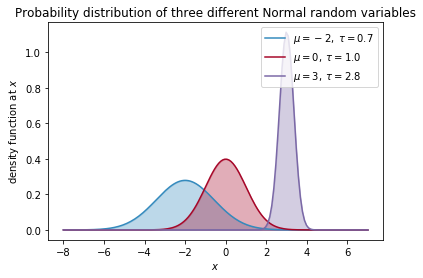

In [4]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./_tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");


In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, 
                                max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
mean_squared_error(y_test, est.predict(X_test))    

3.89600475532934

In [68]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "loss":["ls"],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 3),
    "min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "max_depth":[1,3,5,8],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    "subsample":[0.25,0.5, 0.75, 1.0],#[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10,100,500]
    }

In [69]:
import datetime

dt0=datetime.datetime.now()
clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)
print(datetime.datetime.now()-dt0)

0.995512991915
{'learning_rate': 0.2, 'loss': 'ls', 'max_depth': 5, 'min_samples_leaf': 0.10000000000000001, 'min_samples_split': 0.5, 'n_estimators': 500, 'subsample': 0.75}
0:10:05.249716


In [71]:
df_cv=pd.DataFrame()

for i in range(len(clf.cv_results_['params'])):
    df_cv=df_cv.append(clf.cv_results_['params'][i],ignore_index=True)

metrics=['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']

for metr in metrics:
    df_cv[metr]=clf.cv_results_[metr]


In [37]:
list(clf.param_grid.keys())

['loss',
 'learning_rate',
 'min_samples_split',
 'min_samples_leaf',
 'max_depth',
 'subsample',
 'n_estimators']

In [73]:
df_cv.shape

(2160, 11)

In [55]:
df_cv[['loss','mean_test_score','mean_train_score']] \
            .groupby(['loss']).agg({'mean','max','min'})

mean_test_score                     mean_train_score                    
                mean       min       max             mean       min       max
loss                                                                         
ls          0.169769 -0.049529  0.681406         0.230344 -0.001428  0.836191

In [64]:
list(clf.param_grid.keys())

['loss',
 'learning_rate',
 'min_samples_split',
 'min_samples_leaf',
 'max_depth',
 'subsample',
 'n_estimators']

In [60]:
summary

mean_test_score                     mean_train_score  \
                            mean       min       max             mean   
min_samples_leaf                                                        
0.1                     0.314923  0.013622  0.681406         0.399139   
0.3                     0.200066 -0.048150  0.515851         0.256501   
0.5                    -0.005684 -0.049529  0.379841         0.035391   

                                      
                       min       max  
min_samples_leaf                      
0.1               0.060508  0.836191  
0.3              -0.001428  0.627003  
0.5              -0.001171  0.422378

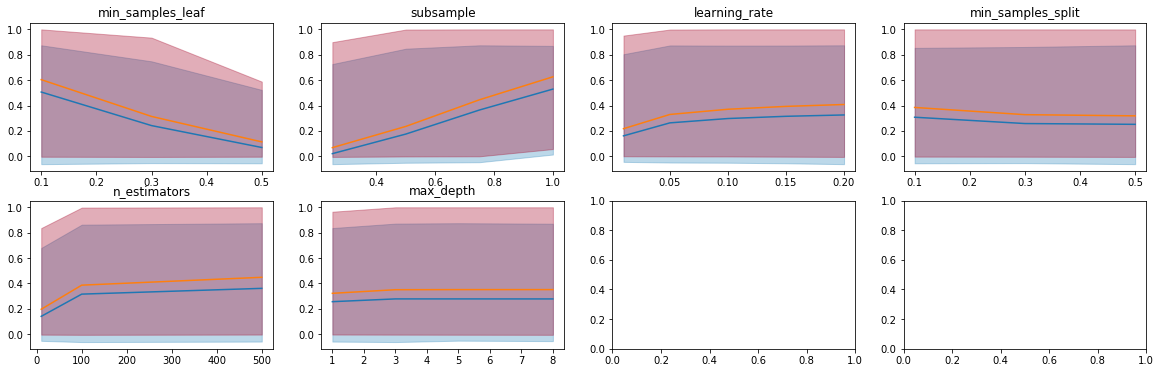

In [76]:
fig, axs = plt.subplots(2,4, figsize=(20, 6), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i , key in enumerate(list(clf.param_grid.keys()-{'loss'})):
    summary=df_cv[[key,'mean_test_score','mean_train_score']] \
                .groupby([key]).agg({'mean','max','min'})
    axs[i].plot(summary[('mean_test_score','mean')])
    #colors = ["#348ABD", "#A60628", "#7A68A6"]
    axs[i].fill_between(list(summary.index), 
                        summary[('mean_test_score','min')],
                        summary[('mean_test_score','max')], 
                        color="#348ABD", alpha=.33)
    axs[i].plot(summary[('mean_train_score','mean')])
    axs[i].fill_between(list(summary.index), 
                        summary[('mean_train_score','min')],
                        summary[('mean_train_score','max')], 
                        color="#A60628", alpha=.33)
    #axs[i].plot(summary[('mean_test_score','min')])
    #axs[i].plot(summary[('mean_test_score','max')])
    axs[i].set_title(key)

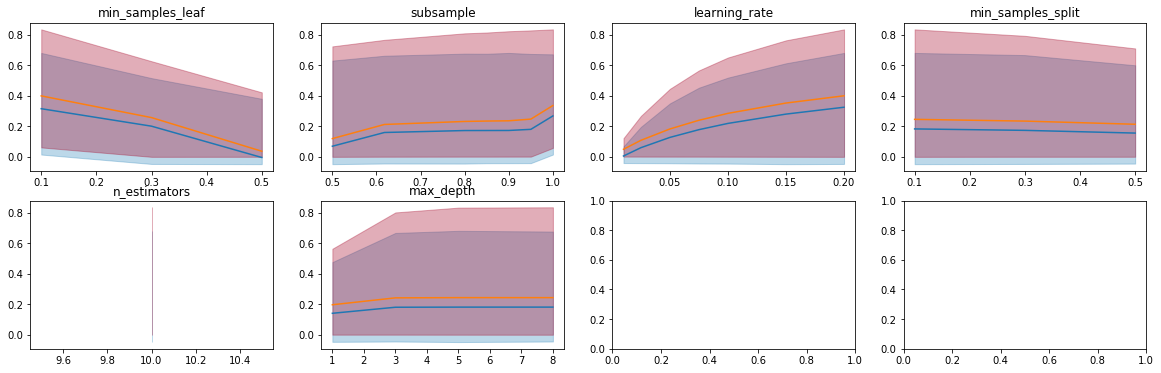

In [70]:
fig, axs = plt.subplots(2,4, figsize=(20, 6), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i , key in enumerate(list(clf.param_grid.keys()-{'loss'})):
    summary=df_cv[[key,'mean_test_score','mean_train_score']] \
                .groupby([key]).agg({'mean','max','min'})
    axs[i].plot(summary[('mean_test_score','mean')])
    #colors = ["#348ABD", "#A60628", "#7A68A6"]
    axs[i].fill_between(list(summary.index), 
                        summary[('mean_test_score','min')],
                        summary[('mean_test_score','max')], 
                        color="#348ABD", alpha=.33)
    axs[i].plot(summary[('mean_train_score','mean')])
    axs[i].fill_between(list(summary.index), 
                        summary[('mean_train_score','min')],
                        summary[('mean_train_score','max')], 
                        color="#A60628", alpha=.33)
    #axs[i].plot(summary[('mean_test_score','min')])
    #axs[i].plot(summary[('mean_test_score','max')])
    axs[i].set_title(key)

In [ ]:
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], color="k",
                s=50, alpha=0.6)